# Final solution

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import itertools
from scipy import stats

In [2]:
data_file = '/home/ajoshi/drive/snippets/toptal/final/Medical-Appointments.csv'
data = pd.read_csv(data_file, dtype={'PatientId': object, 'AppointmentID': object})

In [3]:
data.dtypes

PatientId         object
AppointmentID     object
Gender            object
ScheduledDay      object
AppointmentDay    object
Age                int64
Neighbourhood     object
Scholarship        int64
Hipertension       int64
Diabetes           int64
Alcoholism         int64
Handcap            int64
SMS_received       int64
No-show           object
dtype: object

### Gap
<code>AppointmentDay - ScheduledDay</code> in days.

In [4]:
data['Gap'] = (pd.to_datetime(data['AppointmentDay']) - pd.to_datetime(data['ScheduledDay'])).apply(lambda x: x.days)

### VisitNum
The sequence number of visits of a patient.

In [5]:
data['AppointmentDay'] = pd.to_datetime(data['AppointmentDay'])

In [6]:
data['VisitNum'] = data[['PatientId', 'AppointmentDay']].groupby('PatientId')['AppointmentDay'].rank('dense')

In [7]:
data['VisitNum'] = data['VisitNum'].apply(lambda x: int(x))

### CumNoShow
Cumulative number of no shows. This is where <code>No-show = 1</code> is useful. If we had a variable <code>Show</code> instead of <code>No-show</code> we could not have used a simple cumulative sum.

In [8]:
data['No-show'].unique()

array(['No', 'Yes'], dtype=object)

In [9]:
data['Outcome'] = np.where(data['No-show'] == 'No', 0, 1)

Before running cumulative sum, we sort the data by <code>PatientId</code> **and** <code>AppointmentDay</code>.

In [10]:
data.sort_values(by = ['PatientId', 'AppointmentDay'], inplace=True)

In [11]:
data['CumNoShow'] = data[['PatientId', 'Outcome']].groupby('PatientId').cumsum()

In [12]:
data.loc[(data['VisitNum'] > 2) & (data['Outcome'] == 1)].head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Gap,VisitNum,Outcome,CumNoShow
103284,111415561531417,5721379,F,2016-05-19T16:13:52Z,2016-06-06 00:00:00+00:00,45,SANTA MARTHA,0,0,0,0,0,0,Yes,17,3,1,1
105563,111415561531417,5657853,F,2016-05-04T10:02:43Z,2016-06-06 00:00:00+00:00,45,SANTA MARTHA,0,0,0,0,0,1,Yes,32,3,1,2
97765,111557785928,5761649,F,2016-06-02T06:47:42Z,2016-06-02 00:00:00+00:00,45,CENTRO,0,0,0,0,0,0,Yes,-1,4,1,1
46177,11163631268489,5690667,M,2016-05-12T10:27:18Z,2016-05-20 00:00:00+00:00,35,SANTA MARTHA,0,0,0,0,0,0,Yes,7,4,1,1
108755,11163631268489,5719037,M,2016-05-19T10:29:51Z,2016-06-02 00:00:00+00:00,35,SANTA MARTHA,0,0,0,0,0,1,Yes,13,5,1,2


In [13]:
data.loc[data['PatientId'] == '11163631268489']

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Gap,VisitNum,Outcome,CumNoShow
8590,11163631268489,5665675,M,2016-05-05T15:03:25Z,2016-05-06 00:00:00+00:00,35,SANTA MARTHA,0,0,0,0,0,0,No,0,1,0,0
8547,11163631268489,5669705,M,2016-05-06T11:27:04Z,2016-05-12 00:00:00+00:00,35,SANTA MARTHA,0,0,0,0,0,1,No,5,2,0,0
8529,11163631268489,5690657,M,2016-05-12T10:26:33Z,2016-05-19 00:00:00+00:00,35,SANTA MARTHA,0,0,0,0,0,0,No,6,3,0,0
46177,11163631268489,5690667,M,2016-05-12T10:27:18Z,2016-05-20 00:00:00+00:00,35,SANTA MARTHA,0,0,0,0,0,0,Yes,7,4,1,1
108755,11163631268489,5719037,M,2016-05-19T10:29:51Z,2016-06-02 00:00:00+00:00,35,SANTA MARTHA,0,0,0,0,0,1,Yes,13,5,1,2
88388,11163631268489,5733888,M,2016-05-24T14:37:56Z,2016-06-07 00:00:00+00:00,35,SANTA MARTHA,0,0,0,0,0,1,No,13,6,0,2
109197,11163631268489,5719053,M,2016-05-19T10:30:51Z,2016-06-07 00:00:00+00:00,35,SANTA MARTHA,0,0,0,0,0,1,No,18,6,0,2


## Analysis of variables

In this section we analyze the predictors. We call a predictor **important** if (1) It has a moderate information value and (2) if the $\chi^2$ test of its contingency table with <code>Outcome</code> has a low $p$-value.

In [14]:
def information_value(portion, cname):
    nrows = portion.shape[0]
    ns_0 = portion[[cname, 'Outcome']].groupby(cname).count().iloc[0, 0]
    ns_1 = nrows - ns_0
    
    ns_0 = ns_0/nrows
    ns_1 = ns_1/nrows
    
    if ns_1 > 0:
        iv = (ns_1 - ns_0) * np.log(ns_1/ns_0)
    else:
        iv = 0
        
    return iv

def run_chi2_test(cm):
    results = stats.chi2_contingency(cm)
    pval = results[1]
    print(f'p-values = {pval}')
    if pval < 0.05:
        print('The frequency distributions are NOT similar.')
    else:
        print('The frequency distributions are similar.')

### <code>Hipertension</code>

In [15]:
information_value(data[['Hipertension', 'Outcome']], 'Hipertension')

0.8498895098462262

In [16]:
cm = pd.crosstab(data['Hipertension'], data['Outcome'])
cm.apply(lambda r: r/r.sum(), axis=1)

Outcome,0,1
Hipertension,,
0,0.790963,0.209037
1,0.826980,0.173020


Patients with a hypertension are less likely to miss an appointment.

In [17]:
run_chi2_test(cm)

p-values = 1.9176109238263203e-32
The frequency distributions are NOT similar.


<code>Hipertension</code> **is** an important variable.

### <code>Scholarship</code>

In [18]:
information_value(data[['Scholarship', 'Outcome']], 'Scholarship')

1.7810061449710377

In [19]:
cm = pd.crosstab(data['Scholarship'], data['Outcome'])
cm.apply(lambda r: r/r.sum(), axis=1)

Outcome,0,1
Scholarship,,
0,0.801928,0.198072
1,0.762637,0.237363


Patients who get government aid are more likely to miss an appointment.

In [20]:
run_chi2_test(cm)

p-values = 3.906624913845394e-22
The frequency distributions are NOT similar.


<code>Scholarship</code> **is** an important variable.

### <code>Diabetes</code>

In [21]:
information_value(data[['Diabetes', 'Outcome']], 'Diabetes')

2.1906744661167705

In [22]:
cm = pd.crosstab(data['Diabetes'], data['Outcome'])
cm.apply(lambda r: r/r.sum(), axis=1)

Outcome,0,1
Diabetes,,
0,0.796372,0.203628
1,0.819967,0.180033


Diabetic patients are less likely to miss an appointment.

In [23]:
run_chi2_test(cm)

p-values = 4.849904575233736e-07
The frequency distributions are NOT similar.


<code>Diabetes</code> **is** an important variable.

### <code>Alcoholism</code>

In [24]:
information_value(data[['Alcoholism', 'Outcome']], 'Alcoholism')

3.25193189324057

In [25]:
cm = pd.crosstab(data['Alcoholism'], data['Outcome'])
cm.apply(lambda r: r/r.sum(), axis=1)

Outcome,0,1
Alcoholism,,
0,0.798054,0.201946
1,0.798512,0.201488


Alcholism has **no effect** on patient's behaviour.

In [26]:
run_chi2_test(cm)

p-values = 0.9654188731603915
The frequency distributions are similar.


<code>Alcoholism</code> **is not** an important variable.

### <code>Handcap</code>

In [27]:
information_value(data[['Handcap', 'Outcome']], 'Handcap')

3.720602147222468

In [28]:
pd.crosstab(data['Handcap'], data['Outcome']).apply(lambda r: r/r.sum(), axis=1)

Outcome,0,1
Handcap,,
0,0.797647,0.202353
1,0.820764,0.179236
2,0.797814,0.202186
3,0.769231,0.230769
4,0.666667,0.333333


In [29]:
data[['PatientId', 'Handcap']].groupby('Handcap').count()

,PatientId
Handcap,
0,108286
1,2042
2,183
3,13
4,3


There are too few patients with <code>Handcap</code> values 2, 3, 4. Let us combine all of them into a single category.

In [30]:
data['Handcap'] = np.where(data['Handcap'] == 0, 0, 1)

In [31]:
information_value(data[['Handcap', 'Outcome']], 'Handcap')

3.720602147222468

In [32]:
cm = pd.crosstab(data['Handcap'], data['Outcome'])
cm.apply(lambda r: r/r.sum(), axis=1)

Outcome,0,1
Handcap,,
0,0.797647,0.202353
1,0.818385,0.181615


Handicapped patients are less likely to miss an appointment.

In [33]:
run_chi2_test(cm)

p-values = 0.01666818189588988
The frequency distributions are NOT similar.


<code>Handcap</code> **is** an important variable.

### <code>SMS_received</code>

In [34]:
information_value(data[['SMS_received', 'Outcome']], 'SMS_received')

0.2681259424983039

In [35]:
cm = pd.crosstab(data['SMS_received'], data['Outcome'])
cm.apply(lambda r: r/r.sum(), axis=1)

Outcome,0,1
SMS_received,,
0,0.832967,0.167033
1,0.724255,0.275745


This is strange. People who get an SMS **are more likely to miss an appointment**. The variable seems to be important.

In [36]:
run_chi2_test(cm)

p-values = 0.0
The frequency distributions are NOT similar.


<code>SMS_received</code> **is** an important variable.

### <code>Gender</code>

In [37]:
information_value(data[['Gender', 'Outcome']], 'Gender')

0.18565277992953494

In [38]:
cm = pd.crosstab(data['Gender'], data['Outcome'])
cm.apply(lambda r: r/r.sum(), axis=1)

Outcome,0,1
Gender,,
F,0.796854,0.203146
M,0.800321,0.199679


There is very little difference in the behaviour of male and female patients.

In [39]:
run_chi2_test(cm)

p-values = 0.17338418189785987
The frequency distributions are similar.


<code>Gender</code> **is not** an important variable.

### <code>Gap</code>

In [40]:
information_value(data[['Gap', 'Outcome']], 'Gap')

11.612795927571359

In [41]:
cm = pd.crosstab(data['Gap'], data['Outcome'])
cm.apply(lambda r: r/r.sum(), axis=1)

Outcome,0,1
Gap,,
-7,0.000000,1.000000
-2,0.000000,1.000000
-1,0.953531,0.046469
0,0.786495,0.213505
1,0.761784,0.238216
...,...,...
154,0.400000,0.600000
161,0.818182,0.181818
168,0.875000,0.125000


In [42]:
run_chi2_test(cm)

p-values = 0.0
The frequency distributions are NOT similar.


<code>Gap</code> **is** an important variable.

### <code>VisitNum</code>

In [43]:
information_value(data[['VisitNum', 'Outcome']], 'VisitNum')

0.08070374297881511

In [44]:
cm = pd.crosstab(data['VisitNum'], data['Outcome'])
cm.apply(lambda r: r/r.sum(), axis=1)

Outcome,0,1
VisitNum,,
1,0.806200,0.193800
2,0.783509,0.216491
3,0.778543,0.221457
4,0.763879,0.236121
5,0.782651,0.217349
6,0.803142,0.196858
7,0.829942,0.170058
8,0.838843,0.161157
9,0.833866,0.166134


In [45]:
run_chi2_test(cm)

p-values = 1.0062404058347574e-33
The frequency distributions are NOT similar.


<code>VisitNum</code> is an important variable.

### <code>CumNoShow</code>

In [46]:
information_value(data[['CumNoShow', 'Outcome']], 'CumNoShow')

0.3347368599656829

In [47]:
cm = pd.crosstab(data['CumNoShow'], data['Outcome'])
cm.apply(lambda r: r/r.sum(), axis=1)

Outcome,0,1
CumNoShow,,
0,1.000000,0.000000
1,0.321802,0.678198
2,0.356216,0.643784
3,0.382263,0.617737
4,0.362445,0.637555
5,0.353234,0.646766
6,0.294118,0.705882
7,0.152174,0.847826
8,0.333333,0.666667


In [48]:
run_chi2_test(cm)

p-values = 0.0
The frequency distributions are NOT similar.


<code>CumNoShow</code> is an important variable.

### <code>Age</code>

We first check if there is an age difference between the groups of people who miss an appointment.

In [49]:
data[['Age', 'Outcome']].groupby('Outcome').mean()

,Age
Outcome,
0,37.790064
1,34.317667


Is this difference statistically significant? Before we run the $t$-test we need to know if the group variances are the same.

In [50]:
data[['Age', 'Outcome']].groupby('Outcome').var()

,Age
Outcome,
0,544.703237
1,482.502543


They are different. One is $12.5\%$ higher than the other. So I expect them to be 'statistically different'. Nevertheless, I carry out a formal test to confirm. I choose a non-parametric test because, I haven't checked the distributions of the grouped data.

In [51]:
stats.fligner(data.loc[data['Outcome'] == 0]['Age'], data.loc[data['Outcome'] == 1]['Age'])

FlignerResult(statistic=257.68432284723195, pvalue=5.4863939945304694e-58)

In [52]:
stats.ttest_ind(data.loc[data['Outcome'] == 0]['Age'], data.loc[data['Outcome'] == 1]['Age'], equal_var=False)

Ttest_indResult(statistic=20.82842608183934, pvalue=8.754175118383169e-96)

The group means are indeed quite different.

In [53]:
information_value(data[['Age', 'Outcome']], 'Age')

11.612795927571359

In [54]:
cm = pd.crosstab(data['Age'], data['Outcome'])
cm.apply(lambda r: r/r.sum(), axis=1)

Outcome,0,1
Age,,
-1,1.000000,0.000000
0,0.819441,0.180559
1,0.817422,0.182578
2,0.844252,0.155748
3,0.816920,0.183080
...,...,...
98,0.833333,0.166667
99,1.000000,0.000000
100,1.000000,0.000000


In [55]:
run_chi2_test(cm)

p-values = 1.5734033050726595e-147
The frequency distributions are NOT similar.


### Summary

In [56]:
variables = ['Hipertension', 'Scholarship', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'Gender', \
             'Gap', 'VisitNum', 'CumNoShow', 'Age']
ivals = [0.8498895098462262, 1.7810061449710377, 2.1906744661167705, 3.25193189324057, 3.720602147222468,  \
         0.2681259424983039, 0.18565277992953494, 11.612795927571359, 0.08070374297881511, 0.3347368599656829, \
         11.612795927571359]
chisq = ['Y', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y']
var_analysis = pd.DataFrame({"Vars": variables, "IV": ivals, "ChiSq": chisq})
var_analysis

,Vars,IV,ChiSq
0,Hipertension,0.849890,Y
1,Scholarship,1.781006,Y
2,Diabetes,2.190674,Y
3,Alcoholism,3.251932,N
4,Handcap,3.720602,Y
5,SMS_received,0.268126,Y
6,Gender,0.185653,N
7,Gap,11.612796,Y
8,VisitNum,0.080704,Y
9,CumNoShow,0.334737,Y


Based on this analysis, we choose the variables:
    
* <code>Hipertension</code>
* <code>SMS_receirved</code>
* <code>VisitNum</code>
* <code>CumNoShow</code>

I believe that the variables <code>Age</code> and <code>Gap</code> are also going to be impactful. However, it makes sense to convert them into categorical varibles. One expects a certain age group to have a certain behaviour. The outcome changes when one gets into middle ages than the age increases from $37$ years to $37$ years and $1$ month. Same logic applies to gap as well. People remember an appointment for a certain duration. After that, they either forget or get well not to need a doctor.

## Binning of variables
Veriables like <code>Age, Gap, VisitNum</code> and <code>CumNoShow</code> have a large number of levels. We should try to reduce them so that we can use techniques like CHAID or Random Forest classifier.

### <code>Age</code>

In [57]:
children = [-3] * 9
young_adults = [-2] * 10
adults = [-1] * 12
late_adults = [0] * 15
middle_ages = [1] * 20
old = [2] * 20
very_old = [3] * 35

age_maps = [children, young_adults, adults, late_adults, middle_ages, old, very_old]

In [58]:
import itertools

In [59]:
age_group = [x for x in itertools.chain.from_iterable(age_maps)]
age = [n for n in range(len(age_group))]

In [60]:
age_group = [x for x in itertools.chain.from_iterable(age_maps)]
age = [n for n in range(len(age_group))]

In [61]:
age_map = pd.DataFrame({"Age": age, "Age.Grp": age_group})

In [62]:
age_map.head()

,Age,Age.Grp
0,0,-3
1,1,-3
2,2,-3
3,3,-3
4,4,-3


In [63]:
data_1 = data.merge(age_map, on=['Age'])

In [64]:
data_1.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Gap,VisitNum,Outcome,CumNoShow,Age.Grp
0,11111462625267,5715720,F,2016-05-18T14:58:29Z,2016-06-08 00:00:00+00:00,65,REPÚBLICA,0,1,0,0,0,1,No,20,1,0,0,1
1,112182719252,5621613,F,2016-04-26T10:32:51Z,2016-05-16 00:00:00+00:00,65,DA PENHA,0,1,1,0,0,0,Yes,19,1,1,1,1
2,112182719252,5748776,F,2016-05-31T07:16:38Z,2016-06-06 00:00:00+00:00,65,DA PENHA,0,1,1,0,0,1,No,5,2,0,1,1
3,11415436912447,5696867,M,2016-05-13T14:29:51Z,2016-05-30 00:00:00+00:00,65,SANTA LUÍZA,0,0,0,0,0,1,No,16,1,0,0,1
4,115167768551541,5609492,M,2016-04-20T15:59:42Z,2016-05-12 00:00:00+00:00,65,JABOUR,0,0,0,0,0,1,No,21,1,0,0,1


In [65]:
information_value(data_1[['Age.Grp', 'Outcome']], 'Age.Grp')

1.2533772950866584

In [66]:
cm = pd.crosstab(data_1['Age.Grp'], data['Outcome'])
cm.apply(lambda r: r/r.sum(), axis=1)

Outcome,0,1
Age.Grp,,
-3,0.795877,0.204123
-2,0.780694,0.219306
-1,0.792484,0.207516
0,0.802314,0.197686
1,0.799393,0.200607
2,0.815501,0.184499
3,0.803448,0.196552


In [67]:
run_chi2_test(cm)

p-values = 9.254784265703411e-10
The frequency distributions are NOT similar.


### <code>Gap</code>

In [68]:
result = data_1[['Gap', 'PatientId']].groupby('Gap').count()
result = result.reset_index()


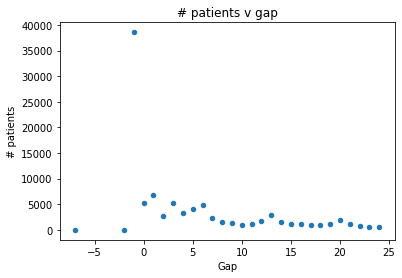

In [69]:
ax = result.loc[result['Gap'] < 25].plot.scatter(x='Gap', y='PatientId')
ignore = ax.set_ylabel('# patients')
ignore = ax.set_title('# patients v gap')


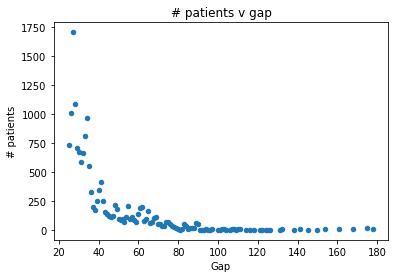

In [70]:
ax = result.loc[result['Gap'] >= 25].plot.scatter(x='Gap', y='PatientId')
ignore = ax.set_ylabel('# patients')
ignore = ax.set_title('# patients v gap')


In [71]:
gap_bins = [-np.Inf, 0, 10, 20, 30, 40, 100, np.Inf]
gap_grps = [-3, -2, -1, 0, 1, 2, 3]


In [72]:
X = result['Gap'].unique()
Y = pd.cut(X, bins=gap_bins, labels=gap_grps)

In [73]:
gap_map = pd.DataFrame({"Gap": X, "Gap.Grp": Y})

In [74]:
gap_map

,Gap,Gap.Grp
0,-7,-3
1,-2,-3
2,-1,-3
3,0,-3
4,1,-2
...,...,...
126,154,3
127,161,3
128,168,3
129,175,3


In [75]:
data_2 = data_1.merge(gap_map, on='Gap')

In [76]:
data_2.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Gap,VisitNum,Outcome,CumNoShow,Age.Grp,Gap.Grp
0,11111462625267,5715720,F,2016-05-18T14:58:29Z,2016-06-08 00:00:00+00:00,65,REPÚBLICA,0,1,0,0,0,1,No,20,1,0,0,1,-1
1,27839116673924,5704283,F,2016-05-16T15:26:05Z,2016-06-06 00:00:00+00:00,65,REPÚBLICA,0,1,0,0,0,1,No,20,1,0,0,1,-1
2,28921186772169,5659068,F,2016-05-04T13:04:31Z,2016-05-25 00:00:00+00:00,65,NOVA PALESTINA,0,1,0,0,0,1,No,20,1,0,0,1,-1
3,33397329857311,5679333,F,2016-05-10T09:47:26Z,2016-05-31 00:00:00+00:00,65,BONFIM,0,1,1,0,0,1,No,20,1,0,0,1,-1
4,387253262878855,5674278,M,2016-05-09T10:44:40Z,2016-05-30 00:00:00+00:00,65,SANTOS DUMONT,0,0,0,1,0,1,Yes,20,1,1,1,1,-1


From out previous experiments we know that <code>Gap</code> and <code>Age</code> are important. We retain both attributes along with their 'binned' attributes <code>Gap.Grp</code> and <code>Age.Grp</code>.

In [77]:
cols_to_be_dropped = ['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Neighbourhood', \
                      'Diabetes', 'Alcoholism', 'Handcap', 'No-show']

In [78]:
data_2.drop(columns=cols_to_be_dropped, inplace=True)

In [79]:
data_2.head()

,Age,Scholarship,Hipertension,SMS_received,Gap,VisitNum,Outcome,CumNoShow,Age.Grp,Gap.Grp
0,65,0,1,1,20,1,0,0,1,-1
1,65,0,1,1,20,1,0,0,1,-1
2,65,0,1,1,20,1,0,0,1,-1
3,65,0,1,1,20,1,0,0,1,-1
4,65,0,0,1,20,1,1,1,1,-1


In [80]:
data_2.to_csv('model_data.csv', index=False)